# ME5413 Homework 3: Planning

## Task 0: Load the Map

In [1]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

/var/folders/ym/58kmv7s1381c8d_y9y_myvs40000gn/T/ipykernel_14911/187924686.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  floor_plan = imageio.imread('./map/vivocity.png')
/var/folders/ym/58kmv7s1381c8d_y9y_myvs40000gn/T/ipykernel_14911/187924686.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  grid_map_img = imageio.imread('./map/vivocity_freespace.png')


Size of the map: (1000, 1000)
Occupied Cells: 823039
Free Cells: 176961


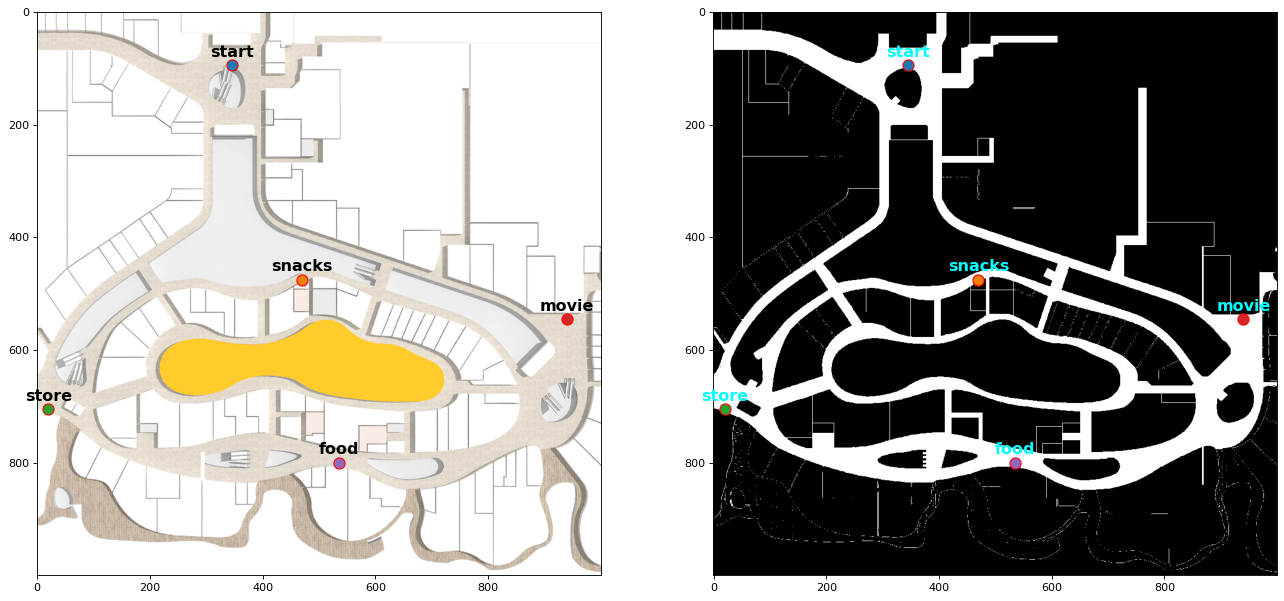

Cell start is free: True
Cell snacks is free: True
Cell store is free: True
Cell movie is free: True
Cell food is free: True


In [2]:
# Load the map
floor_plan = imageio.imread('./map/vivocity.png')
grid_map_img = imageio.imread('./map/vivocity_freespace.png')
grid_map = grid_map_img.transpose()
print("Size of the map:", grid_map.shape)
print("Occupied Cells:", np.count_nonzero(grid_map == 0))
print("Free Cells:", np.count_nonzero(grid_map == 255))

# Map resolution (Constant)
MAP_RES = 0.2 # each cell represents a 0.2m x 0.2m square in reality

# Locations on the map
locations = {'start':  [345, 95],    # Start from the level 2 Escalator
             'snacks': [470, 475],   # Garrett Popcorn
             'store':  [20, 705],    # DJI Store
             'movie':  [940, 545],   # Golden Village
             'food':   [535, 800],   # PUTIEN
            }

# A helper function to mark the locations on the map
def plot_locations(locations: dict, color: 'str'='black'):
    for key, value in locations.items():
        plt.plot(locations[key][0], locations[key][1], marker="o", markersize=10, markeredgecolor="red")
        plt.text(locations[key][0], locations[key][1]-15, s=key, fontsize='x-large', fontweight='bold', c=color, ha='center')
    return

# Plot the locaitons on the map 
plt.figure(figsize=(20, 10), dpi=80)
plt.subplot(1,2,1)
plt.imshow(floor_plan)
plot_locations(locations)
plt.subplot(1,2,2)
plt.imshow(grid_map_img, cmap='gray')
plot_locations(locations, color='cyan')
plt.show()

# Check if the designated locations are free
for key, value in locations.items():
    print(f"Cell {key} is free: {grid_map[value[0], value[1]] == 255}")

In [3]:
import time
import itertools
from heapq import heappush, heappop

## Task 1

A* from start to snacks result:
  - Node number: 47268
  - Path length: 143.920
  - Time: 0.2737
A* from start to store result:
  - Node number: 42303
  - Path length: 155.836
  - Time: 0.2171
A* from start to movie result:
  - Node number: 44420
  - Path length: 179.359
  - Time: 0.2205
A* from start to food result:
  - Node number: 105398
  - Path length: 225.675
  - Time: 0.5607
A* from snacks to store result:
  - Node number: 21523
  - Path length: 115.595
  - Time: 0.1069
A* from snacks to movie result:
  - Node number: 11784
  - Path length: 108.475
  - Time: 0.0569
A* from snacks to food result:
  - Node number: 37200
  - Path length: 135.166
  - Time: 0.1862
A* from store to movie result:
  - Node number: 75907
  - Path length: 210.314
  - Time: 0.3831
A* from store to food result:
  - Node number: 17568
  - Path length: 111.201
  - Time: 0.0868
A* from movie to food result:
  - Node number: 40191
  - Path length: 113.958
  - Time: 0.2037

Best Sequence:
  start -> snacks -> mo

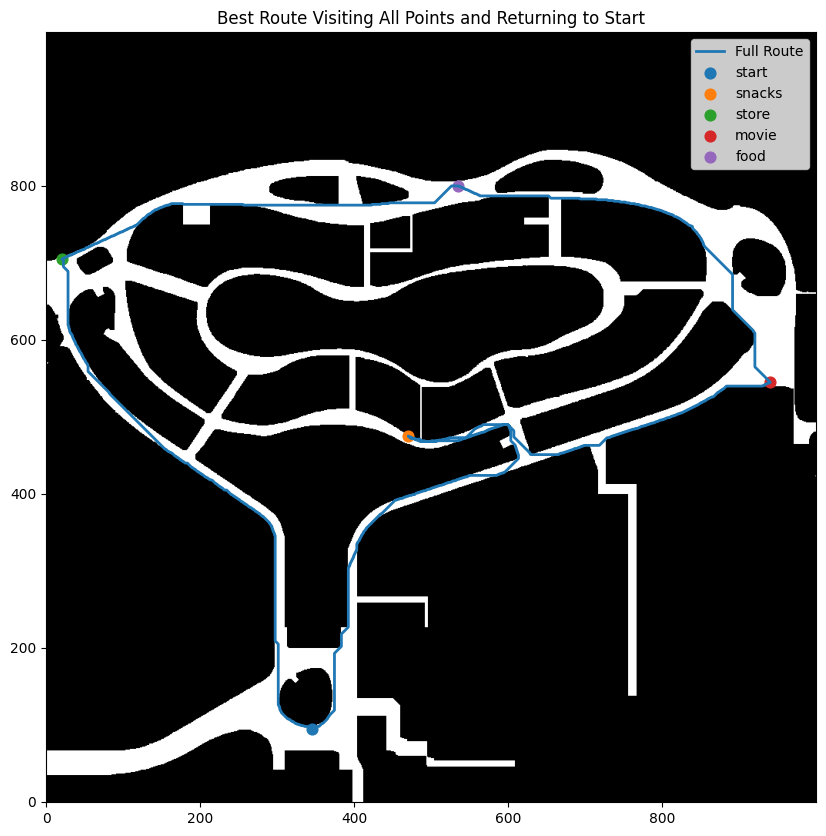

In [4]:
# -------------------------------
#  Inflation func（0.3m）
# -------------------------------
def inflate_obstacles(grid_map: np.ndarray, inflation_radius: float = 0.3) -> np.ndarray:
    """
    Inflat according to radius
    """
    # grid number
    inflate_cells = int(np.ceil(inflation_radius / MAP_RES))

    inflated_map = grid_map.copy()

    # obstacle coordinates
    obstacle_indices = np.argwhere(inflated_map == 0)

    # Inflate the obstacles
    for (ox, oy) in obstacle_indices:
        min_x = max(0, ox - inflate_cells)
        max_x = min(inflated_map.shape[0]-1, ox + inflate_cells)
        min_y = max(0, oy - inflate_cells)
        max_y = min(inflated_map.shape[1]-1, oy + inflate_cells)
        inflated_map[min_x:max_x+1, min_y:max_y+1] = 0

    return inflated_map

inflated_map = inflate_obstacles(grid_map, 0.3)

# -------------------------------
#  A* Search Algorithm
# -------------------------------
def heuristic_euclidean(curr, goal):
    """
    Heuristic function: Euclidean distance
    """
    dx = curr[0] - goal[0]
    dy = curr[1] - goal[1]
    return np.sqrt(dx*dx + dy*dy) * MAP_RES

def heuristic_manhattan(curr, goal):
    """
    Heuristic function: Manhattan distance
    """
    dx = abs(curr[0] - goal[0])
    dy = abs(curr[1] - goal[1])
    return (dx + dy) * MAP_RES

def astar_search(grid_map: np.ndarray, start: tuple, goal: tuple,
                 heuristic_func=heuristic_euclidean):
    """
    A* Search Algorithm
    """
    t0 = time.time()
    
    if grid_map[start[0], start[1]] == 0 or grid_map[goal[0], goal[1]] == 0:
        return [], [], float('inf'), 0.0
    
    open_set = []
    visited_list = []
    g_cost_map = dict()
    g_cost_map[start] = 0.0
    came_from = dict()
    
    start_h = heuristic_func(start, goal)
    heappush(open_set, (start_h, start, 0.0))
    
    # 8 neighbors (4 + 4 diagonal)
    neighbors_8 = [
        (-1,  0, 0.2), (1,  0, 0.2), 
        (0, -1, 0.2), (0,  1, 0.2),
        (-1, -1, 0.2*np.sqrt(2)), (-1, 1, 0.2*np.sqrt(2)),
        (1, -1, 0.2*np.sqrt(2)), (1,  1, 0.2*np.sqrt(2))
    ]
    
    found_path = False
    
    while open_set:
        f_val, current, current_g = heappop(open_set)
        
        if current == goal:
            found_path = True
            break
        
        visited_list.append(current)
        
        for (dx, dy, step_cost) in neighbors_8:
            nx = current[0] + dx
            ny = current[1] + dy
            neighbor = (nx, ny)
            
            if nx < 0 or nx >= grid_map.shape[0] or ny < 0 or ny >= grid_map.shape[1]:
                continue
            
            if grid_map[nx, ny] == 0:
                continue
            
            new_cost = current_g + step_cost
            
            if (neighbor not in g_cost_map) or (new_cost < g_cost_map[neighbor]):
                g_cost_map[neighbor] = new_cost
                came_from[neighbor] = current
                h_val = heuristic_func(neighbor, goal)
                f_val_new = new_cost + h_val
                heappush(open_set, (f_val_new, neighbor, new_cost))
    
    runtime = time.time() - t0
    
    path = []
    total_cost = float('inf')
    if found_path:
        total_cost = g_cost_map[goal]
        cur = goal
        while cur != start:
            path.append(cur)
            cur = came_from[cur]
        path.append(start)
        path.reverse()
        
    return path, visited_list, total_cost, runtime


# -------------------------------
#   Calculate path and plot
# -------------------------------
def compute_path_and_plot(grid_map, start_key, goal_key, locations, 
                          heuristic_func=heuristic_euclidean, show_plot=True):
    """
    Calculate path and plot
    """
    start_pt = (locations[start_key][0], locations[start_key][1])
    goal_pt  = (locations[goal_key][0], locations[goal_key][1])
    
    path, visited_list, total_cost, runtime = astar_search(
        grid_map, start_pt, goal_pt, heuristic_func=heuristic_func
    )
    
    # Print the results
    print(f"A* from {start_key} to {goal_key} result:")
    print(f"  - Node number: {len(visited_list)}")
    print(f"  - Path length: {total_cost:.3f}")
    print(f"  - Time: {runtime:.4f}")
    
    if show_plot and len(path) > 0:
        plt.figure(figsize=(8,8))
        plt.imshow(grid_map.T, cmap='gray', origin='lower')
        vx = [v[0] for v in visited_list]
        vy = [v[1] for v in visited_list]
        plt.scatter(vx, vy, s=1, c='blue', label='Visited')
        px = [p[0] for p in path]
        py = [p[1] for p in path]
        plt.plot(px, py, linewidth=2, label='Path')
        plt.scatter([start_pt[0]], [start_pt[1]], marker='o', c='red', s=50, label='Start')
        plt.scatter([goal_pt[0]], [goal_pt[1]], marker='x', c='green', s=50, label='Goal')
        plt.legend()
        plt.title(f"Path from {start_key} to {goal_key}")
        plt.show()
    
    return total_cost


# -------------------------------
all_points = list(locations.keys())  # ['start', 'snacks', 'store', 'movie', 'food']

pairwise_dist = {}
for i in range(len(all_points)):
    for j in range(len(all_points)):
        if i == j:
            continue
        key1 = all_points[i]
        key2 = all_points[j]
        if (key1, key2) not in pairwise_dist and (key2, key1) not in pairwise_dist:
            d = compute_path_and_plot(inflated_map, key1, key2, locations,
                                      heuristic_func=heuristic_euclidean, 
                                      show_plot=False)
            pairwise_dist[(key1, key2)] = d
            pairwise_dist[(key2, key1)] = d

import math

waypoints = [p for p in all_points if p != 'start']  # ['snacks', 'store', 'movie', 'food']
best_order = None
best_dist = math.inf

for perm in itertools.permutations(waypoints):
    # Calculate start -> perm[0] -> perm[1] -> ... -> perm[3] -> start distance
    route_list = ['start'] + list(perm) + ['start']
    total_d = 0.0
    for k in range(len(route_list)-1):
        p1 = route_list[k]
        p2 = route_list[k+1]
        total_d += pairwise_dist[(p1, p2)]
    if total_d < best_dist:
        best_dist = total_d
        best_order = perm

print("\n========================================")
print("Best Sequence:")
print(f"  start -> {' -> '.join(best_order)} -> start")
print(f"  Total Distance = {best_dist:.3f}")
print("========================================\n")

full_route_pairs = []
final_route_list = ['start'] + list(best_order) + ['start']

overall_path_coords = []

def retrieve_full_path(grid_map, from_key, to_key):
    """
    Retrieve the full path between two points using A* search
    """
    sp = (locations[from_key][0], locations[from_key][1])
    gp = (locations[to_key][0], locations[to_key][1])
    path, visited, cost, _ = astar_search(grid_map, sp, gp)
    return path

for k in range(len(final_route_list)-1):
    p1 = final_route_list[k]
    p2 = final_route_list[k+1]
    seg_path = retrieve_full_path(inflated_map, p1, p2)
    overall_path_coords.extend(seg_path)

# Plot the full route
plt.figure(figsize=(10,10))
plt.title("Best Route Visiting All Points and Returning to Start")
plt.imshow(inflated_map.T, cmap='gray', origin='lower')
px = [p[0] for p in overall_path_coords]
py = [p[1] for p in overall_path_coords]
plt.plot(px, py, linewidth=2, label='Full Route')
for key in locations:
    plt.scatter(locations[key][0], locations[key][1], marker='o', s=60, label=key)
plt.legend()
plt.show()


Dijkstra

A* from start to snacks result:
  - Node number: 67200
  - Path length: 143.920
  - Time: 0.2782
A* from start to store result:
  - Node number: 78213
  - Path length: 155.836
  - Time: 0.3216
A* from start to movie result:
  - Node number: 91610
  - Path length: 179.359
  - Time: 0.3902
A* from start to food result:
  - Node number: 137911
  - Path length: 225.675
  - Time: 0.5794
A* from snacks to store result:
  - Node number: 70129
  - Path length: 115.595
  - Time: 0.3090
A* from snacks to movie result:
  - Node number: 57079
  - Path length: 108.475
  - Time: 0.2364
A* from snacks to food result:
  - Node number: 104581
  - Path length: 135.166
  - Time: 0.4457
A* from store to movie result:
  - Node number: 135416
  - Path length: 210.314
  - Time: 0.5632
A* from store to food result:
  - Node number: 51368
  - Path length: 111.201
  - Time: 0.2186
A* from movie to food result:
  - Node number: 54189
  - Path length: 113.958
  - Time: 0.2235

Best sequence:
  start -> snacks -> 

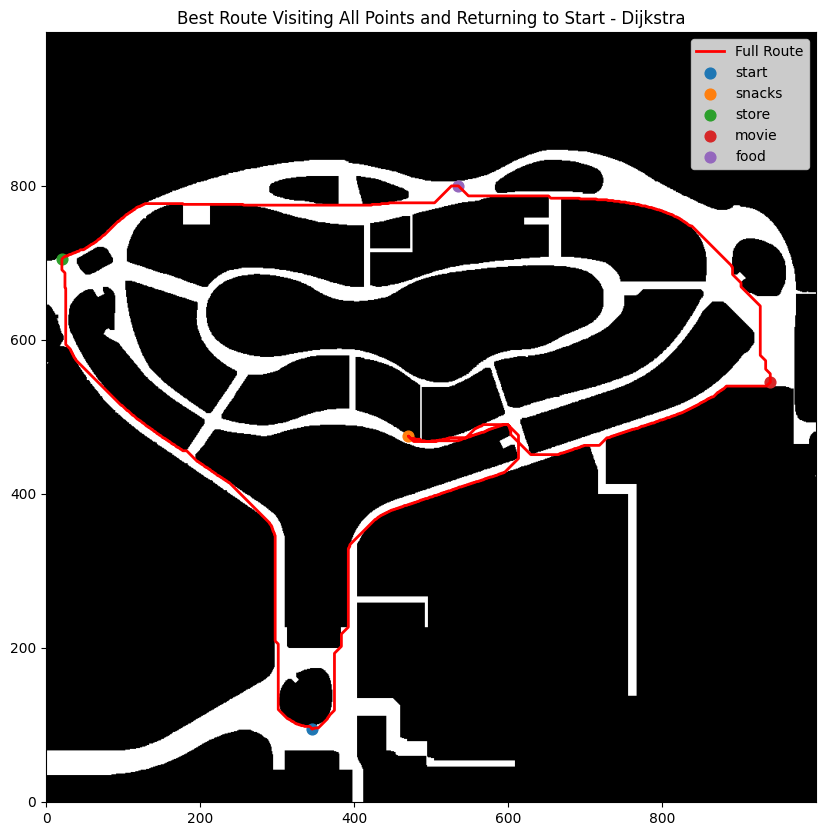

In [5]:
# -------------------------------
# Dijkstra Algo
# -------------------------------
def heuristic_zero(curr, goal):
    return 0

all_points = list(locations.keys())  # ['start', 'snacks', 'store', 'movie', 'food']

pairwise_dist = {}
for i in range(len(all_points)):
    for j in range(len(all_points)):
        if i == j:
            continue
        key1 = all_points[i]
        key2 = all_points[j]
        if (key1, key2) not in pairwise_dist and (key2, key1) not in pairwise_dist:
            d = compute_path_and_plot(inflated_map, key1, key2, locations,
                                      heuristic_func=heuristic_zero,
                                      show_plot=False)
            pairwise_dist[(key1, key2)] = d
            pairwise_dist[(key2, key1)] = d

import itertools
import math

waypoints = [p for p in all_points if p != 'start']  # ['snacks', 'store', 'movie', 'food']
best_order = None
best_dist = math.inf

for perm in itertools.permutations(waypoints):
    # Calculate start -> perm[0] -> perm[1] -> ... -> perm[-1] -> start distance
    route_list = ['start'] + list(perm) + ['start']
    total_d = 0.0
    for k in range(len(route_list)-1):
        p1 = route_list[k]
        p2 = route_list[k+1]
        total_d += pairwise_dist[(p1, p2)]
    if total_d < best_dist:
        best_dist = total_d
        best_order = perm

print("\n========================================")
print("Best sequence:")
print(f"  start -> {' -> '.join(best_order)} -> start")
print(f"  Full Route = {best_dist:.3f}")
print("========================================\n")

final_route_list = ['start'] + list(best_order) + ['start']
overall_path_coords = []

def retrieve_full_path_dijkstra(grid_map, from_key, to_key):
    """
    Retrieve the full path between two points using Dijkstra search
    """
    sp = (locations[from_key][0], locations[from_key][1])
    gp = (locations[to_key][0], locations[to_key][1])
    path, visited, cost, _ = astar_search(grid_map, sp, gp, heuristic_func=heuristic_zero)
    return path

for k in range(len(final_route_list)-1):
    p1 = final_route_list[k]
    p2 = final_route_list[k+1]
    seg_path = retrieve_full_path_dijkstra(inflated_map, p1, p2)
    overall_path_coords.extend(seg_path)

plt.figure(figsize=(10,10))
plt.title("Best Route Visiting All Points and Returning to Start - Dijkstra")
plt.imshow(inflated_map.T, cmap='gray', origin='lower')
px = [p[0] for p in overall_path_coords]
py = [p[1] for p in overall_path_coords]
plt.plot(px, py, linewidth=2, color='red', label='Full Route')
for key in locations:
    plt.scatter(locations[key][0], locations[key][1], marker='o', s=60, label=key)
plt.legend()
plt.show()

In [6]:
import pandas as pd

all_points = ['start', 'snacks', 'store', 'movie', 'food']

# DataFrame
distance_df = pd.DataFrame(index=all_points, columns=all_points, dtype=float)

for row in all_points:
    for col in all_points:
        if row == col:
            distance_df.loc[row, col] = 0.0
        else:
            distance_df.loc[row, col] = pairwise_dist.get((row, col), float('inf'))

# Print
print(distance_df)

             start      snacks       store       movie        food
start     0.000000  143.920014  155.836162  179.359206  225.675353
snacks  143.920014    0.000000  115.594531  108.474935  135.166104
store   155.836162  115.594531    0.000000  210.314127  111.201429
movie   179.359206  108.474935  210.314127    0.000000  113.957778
food    225.675353  135.166104  111.201429  113.957778    0.000000


## Task 2

=== Method 1: Brute Force ===
Route: start -> snacks -> movie -> food -> store -> start
Total Distance: 633.39 m

=== Method 2: Nearest Neighbor ===
Route: start -> snacks -> movie -> food -> store -> start
Total Distance: 633.39 m

Best method: Nearest Neighbor
Best route: start -> snacks -> movie -> food -> store -> start
Best total distance: 633.39 m


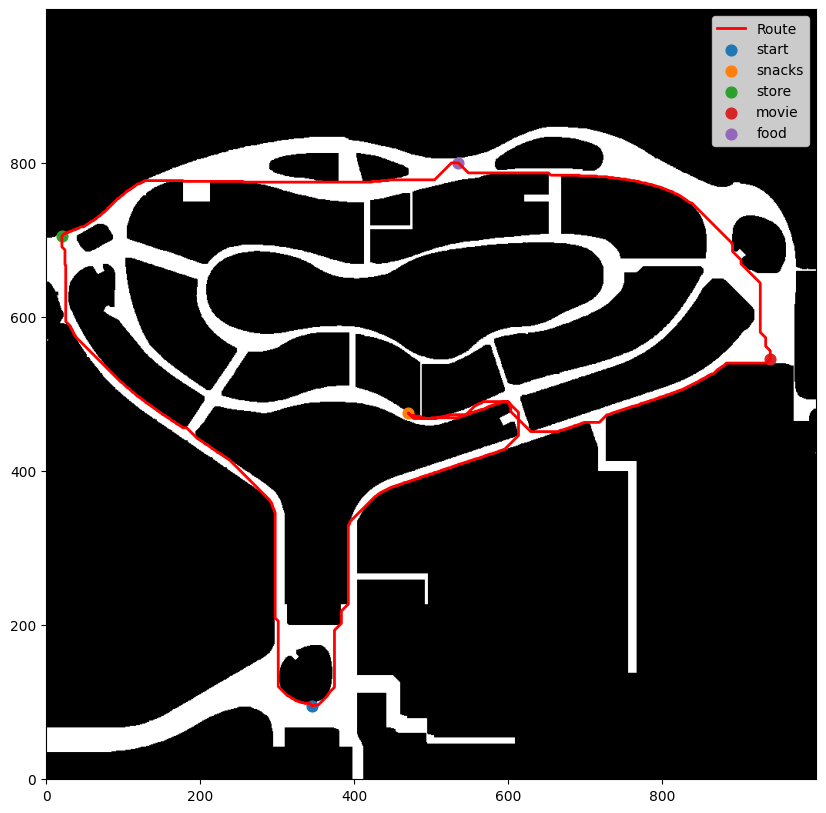

In [7]:
import itertools
import math
import pandas as pd

def route_distance(route, distance_df):
    """
    Given a route and a distance DataFrame,
    compute the total distance by summing the consecutive legs.
    """
    dist_sum = 0.0
    for i in range(len(route) - 1):
        dist_sum += distance_df.loc[route[i], route[i+1]]
    return dist_sum

def tsp_bruteforce(distance_df, start='start'):
    """
    Method 1: Brute Force
    Returns the best route (start -> ... -> start) and the total distance.
    """
    points = list(distance_df.columns)  # e.g. ['start', 'snacks', 'store', 'movie', 'food']
    # Remove the start location from permutations
    waypoints = [p for p in points if p != start]
    
    best_route = None
    best_dist = math.inf
    
    for perm in itertools.permutations(waypoints):
        candidate = [start] + list(perm) + [start]
        dist_sum = route_distance(candidate, distance_df)
        if dist_sum < best_dist:
            best_route = candidate
            best_dist = dist_sum
    
    return best_route, best_dist

def tsp_nearest_neighbor(distance_df, start='start'):
    """
    Method 2: Nearest Neighbor Heuristic.
    Returns the route and total distance.
    """
    points = list(distance_df.columns)
    # All points except the start
    waypoints = [p for p in points if p != start]
    
    unvisited = set(waypoints)
    route = [start]
    current = start
    total_dist = 0.0
    
    while unvisited:
        nearest = None
        best_d = math.inf
        for nxt in unvisited:
            d = distance_df.loc[current, nxt]
            if d < best_d:
                best_d = d
                nearest = nxt
        route.append(nearest)
        total_dist += best_d
        unvisited.remove(nearest)
        current = nearest
    
    # Finally return to start
    total_dist += distance_df.loc[current, start]
    route.append(start)
    
    return route, total_dist

# ------------------------------------------------

# Brute Force
route_bf, dist_bf = tsp_bruteforce(distance_df, start='start')
print("=== Method 1: Brute Force ===")
print("Route:", " -> ".join(route_bf))
print(f"Total Distance: {dist_bf:.2f} m")

# Nearest Neighbor
route_nn, dist_nn = tsp_nearest_neighbor(distance_df, start='start')
print("\n=== Method 2: Nearest Neighbor ===")
print("Route:", " -> ".join(route_nn))
print(f"Total Distance: {dist_nn:.2f} m")

# Compare and choose best
if dist_bf < dist_nn:
    best_route = route_bf
    best_dist  = dist_bf
    best_method = "Brute Force"
else:
    best_route = route_nn
    best_dist  = dist_nn
    best_method = "Nearest Neighbor"

print(f"\nBest method: {best_method}")
print("Best route:", " -> ".join(best_route))
print(f"Best total distance: {best_dist:.2f} m")

# ------------------------------------------------

overall_path_coords = []
for i in range(len(best_route) - 1):
    from_key = best_route[i]
    to_key   = best_route[i+1]
    # Reconstruct the actual path on the grid map
    path, visited, cost, _ = astar_search(
        inflated_map,
        (locations[from_key][0], locations[from_key][1]),
        (locations[to_key][0], locations[to_key][1]),
        heuristic_func=heuristic_zero
    )
    overall_path_coords.extend(path)

# Then plot it
plt.figure(figsize=(10,10))
plt.imshow(inflated_map.T, cmap='gray', origin='lower')
px = [p[0] for p in overall_path_coords]
py = [p[1] for p in overall_path_coords]
plt.plot(px, py, linewidth=2, color='red', label='Route')
# Mark each location
for loc_key, coord in locations.items():
    plt.scatter(coord[0], coord[1], s=60, label=loc_key)
plt.legend()
plt.show()


## Task 3